# SC4061 Computer Vision Lab 1

**Point Processing + Spatial Filtering + Frequency Filtering + Imaging Geometry**

This laborary aims to introduce image processing, supposedly in the MATLAB context. But we are using Python here. We will:
1. Experiment with the point processing operations of contrast stretching and histogram equalization
2. Evaliate how different Gaussian and median filters are suitable for noise removal
3. Become familiar with the frequency domain operations
4. Understand imaging geometry

---

## 1.0 Importing Dependencies and Helper Function Declarations

In [215]:
# Import dependencies, the typical stuff
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy # Used for convolutions
import cv2

In [216]:
# Reimport just for redundancy
import cv2
import matplotlib.pyplot as plt

# Helper function to load images, we are mainly working with greyscale images this lab
def load_image(path, is_greyscale = True):
    image = cv2.imread(path)
    if image is not None and is_greyscale:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return image

# Helper function to display images, we will use this a lot
def display_image(image, figsize = (10, 10), title = "Image", vmin = None, vmax = None):
    if image is None:
        return
    plt.figure(figsize = figsize)
    plt.imshow(image, cmap = "gray", vmin = vmin, vmax = vmax)
    plt.title(title)
    plt.show()

# Helper function to display two images side by side for comparison
def display_images_side_by_side(image1, image2, title1="Image 1", title2="Image 2", figsize=(15, 6)):
    if image1 is None or image2 is None:
        print("One or both images are None")
        return
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Display first image
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title(title1, fontsize=14)
    
    # Display second image
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title(title2, fontsize=14)
    
    plt.tight_layout()
    plt.show()

def print_image_info(image, image_name="Image"):
    if image is None:
        return
    
    # Create a dictionary with image information
    info_data = {
        'Property': [
            'Shape',
            'Data Type',
            'Total Pixels',
            'Dimensions',
            'Memory Usage (bytes)',
            'Min Pixel Value',
            'Max Pixel Value',
            'Mean Pixel Value',
            'Standard Deviation'
        ],
        'Value': [
            str(image.shape),
            str(image.dtype),
            f"{image.size:,}",
            image.ndim,
            f"{image.nbytes:,}",
            image.min(),
            image.max(),
            f"{image.mean():.2f}",
            f"{image.std():.2f}"
        ]
    }
    
    # Create and display the table
    df = pd.DataFrame(info_data)
    print(f"{image_name} Information:")
    print("=" * 40)
    print(df.to_string(index=False, justify='left'))
    print("=" * 40)
    

## 1.1 Contrast Stretching

### Part A and B - Loading of image and converting to greyscale

In [217]:
# Part A and B: Loading of image and converting to greyscale
# Loading of iamge into variable as described by lab manual
P = load_image("../assets/mrt-train.jpg")
# Displaying the image
display_image(P, title = "MRT Train (Grey Scale)")

### Part C - Checking minimum and maximum intensities present in the image

In [218]:
# Also print out some statistics about image
print_image_info(P)

Image Information:
Property             Value     
               Shape (320, 443)
           Data Type      uint8
        Total Pixels    141,760
          Dimensions          2
Memory Usage (bytes)    141,760
     Min Pixel Value         13
     Max Pixel Value        204
    Mean Pixel Value      73.99
  Standard Deviation      49.56


### Part D - Performing Contrast Stretching

In contrast stretching, we want to increase an image's contrast by expanding its pixel intensity values to fill a wider range, such as the full spectrum of 0 to 255 for an 8-bit image. In the current image, our minimum and maximum pixel intensities are 13, and 204 respectively.

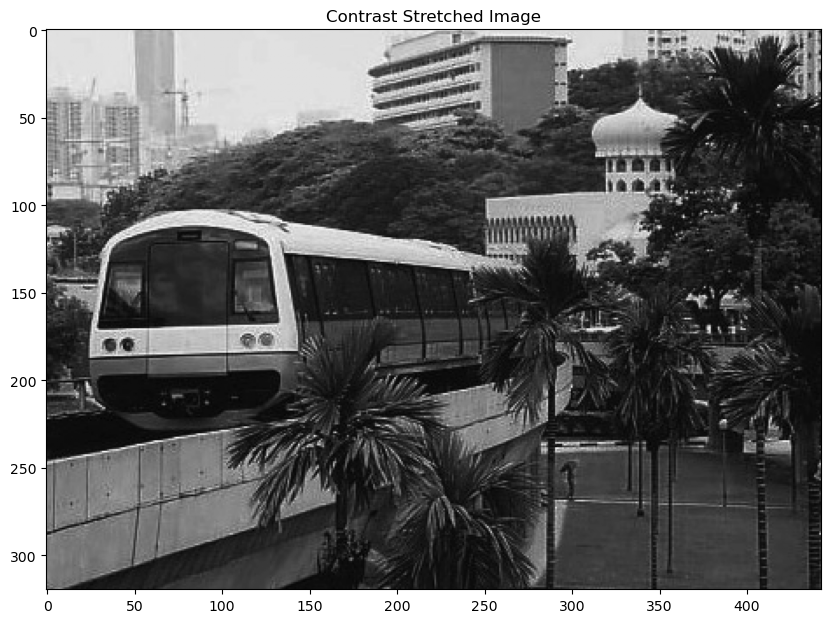

Contrast Stretched Image Information:
Property             Value     
               Shape (320, 443)
           Data Type    float64
        Total Pixels    141,760
          Dimensions          2
Memory Usage (bytes)  1,134,080
     Min Pixel Value        0.0
     Max Pixel Value      255.0
    Mean Pixel Value      81.43
  Standard Deviation      66.17


In [219]:
# Create newly contrast stretched image using the min and max values specifically
P2 = (P - P.min()) / (P.max() - P.min()) * 255.0
# Display the newly contrast stretched image and its information
display_image(P2, title = "Contrast Stretched Image")
print_image_info(P2, "Contrast Stretched Image")

Observations: The pixel with the leaset intensity, is now a value of 0. The pixel with the highest intensity is now 255, with all pixels in between these ranges scaled in propoertion. The pixel intensities will now fully utilize the uint8 range (0-255), which has enhanced the image contrast.

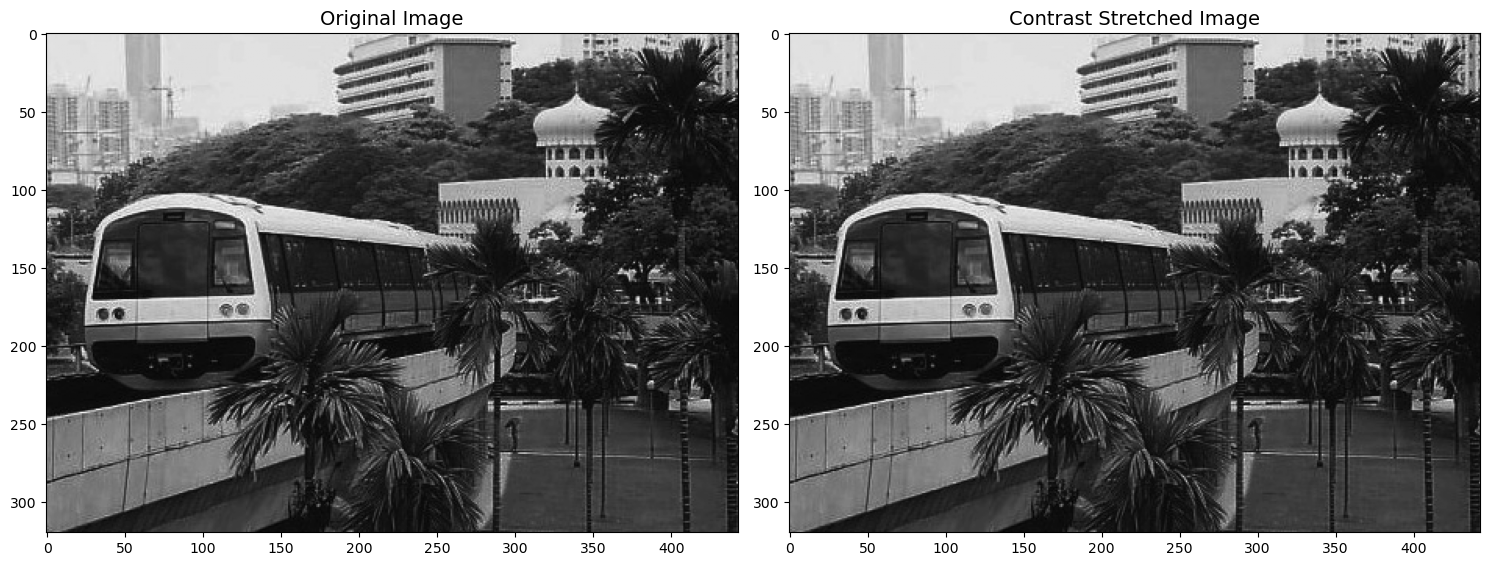

In [220]:
display_images_side_by_side(P, P2, title1 = "Original Image", title2 = "Contrast Stretched Image")

---
## 1.2 Histogram Equalization

Histogram equalization typically involves nonlinearly mapping some gray levels to other levels, in order to create a resultant histogram which is approximately uniform. In image processing, it typcially improves an image's contrast by redistributing its pixel intensity values through analysis of its intensity histogram to create a transformation function that stretches the distribution to occupy the full possible range. This may or may not enhance detail and visibility in images with a narrow range of intensities.

### Part A - Displaying of intensity histogram with 256 and 10 bins

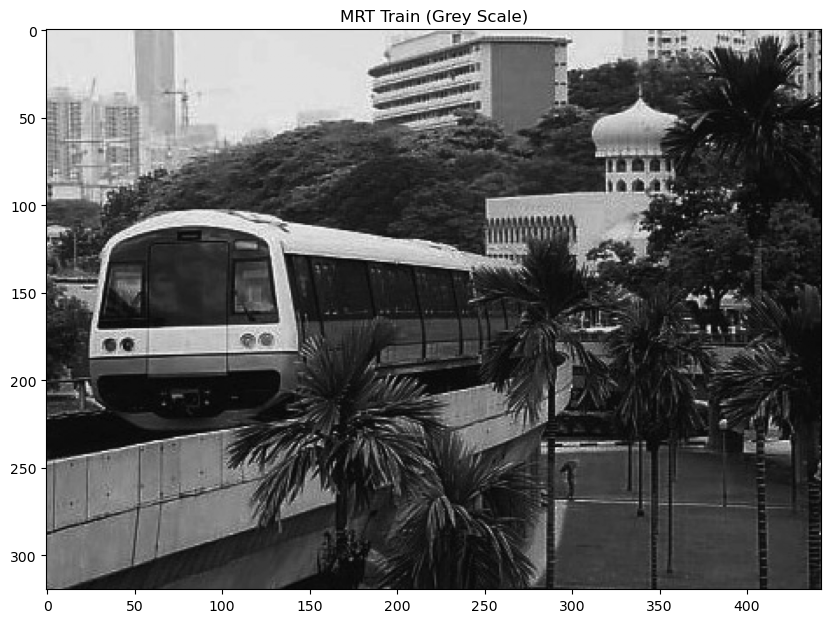

Original Image Information:
Property             Value     
               Shape (320, 443)
           Data Type      uint8
        Total Pixels    141,760
          Dimensions          2
Memory Usage (bytes)    141,760
     Min Pixel Value         13
     Max Pixel Value        204
    Mean Pixel Value      73.99
  Standard Deviation      49.56


In [221]:
# Reload the image P again to get saved state
# This will be using the image with the min itensity 13 and max intensity 204
P = load_image("../assets/mrt-train.jpg")
display_image(P, title = "MRT Train (Grey Scale)")
print_image_info(P, "Original Image")

In [222]:
def plot_intensity_histogram(image, bins, range = (0, 255), title = "Image"):
    # I think we can also use flatten over ravel - but flatten does occupy memory so we use ravel here for simplicity
    plt.hist(image.ravel(), bins = bins, range = range)
    plt.title(f"{title} ({bins} bins)")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

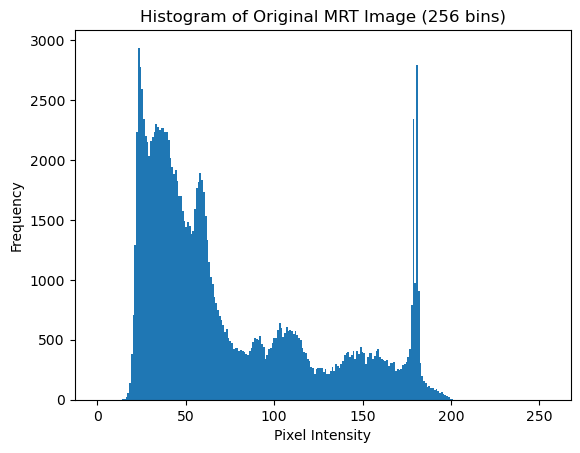

In [223]:
# Plotting out intensity histogram with 10 bins
plot_intensity_histogram(P, 10, (0, 255), "Histogram of Original MRT Image")
# Plotting out intensity histogram with 256 bins
plot_intensity_histogram(P, 256, (0, 255), "Histogram of Original MRT Image")

**Differences between a histogram with 10 bins and 256 bins**
The key difference between both histograms is ultimately the granularity of detail.

In the 10 bins histogram: It groups 256 possible intesity values into just 10 broad categories (with each bin covering ~25-26 intensity levels), giving a simplified and high level view of the distribution. It allows us to make the inference that the image is predominantly dark with a gradual decrease towards brighter values.

In the 256 bins histogram: Each individual intensity value is shown seperately, revealing fine-grained details that the 10-bin version misses. Specifically, we can see a bimodal distribution with a large peak around intensity 20-50 (the dark train/background) and a distinct spike around intensity 200 (likely the bright train lights or signage).

While the 10-bin histogram is useful for quick analysis and identifying general trends, the 256-bin histogram provides the complete picture which is necessary for precise analysis like histogram equalization, where we may need to know exactly how many pixels exist at specific intensity level in order for proper redistribgution across the 0-255 range. Since the range is small, it is still okay to have a histogram for each bin at small computational cost.

### Part B - Histogram Equalization on Image

Since we are not using MATLAB, as part of cv2's docs, it comes with histogram equalization: https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html
https://docs.opencv.org/4.x/d6/dc7/group__imgproc__hist.html#ga7e54091f0c937d49bf84152a16f76d6e

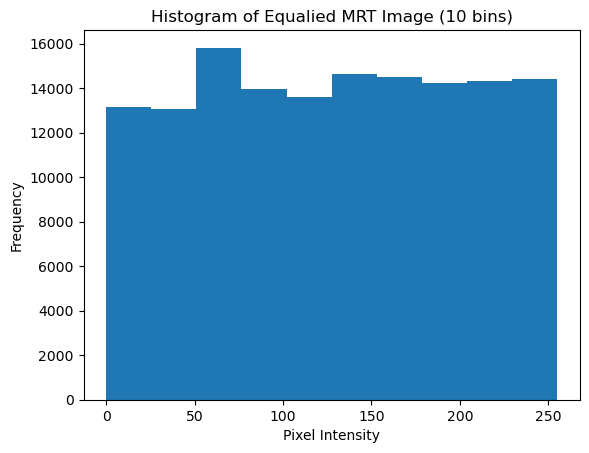

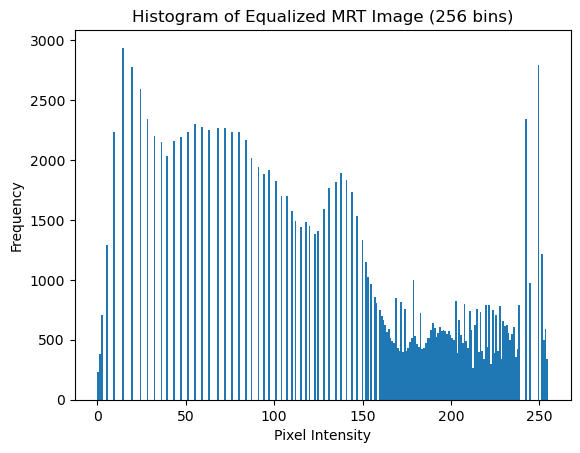

In [224]:
# Use cv2's histogram equalization
P3 = cv2.equalizeHist(P)

# Redisplay the histograms for P3 with 10 and 256 bins
plot_intensity_histogram(P3, 10, (0, 255), "Histogram of Equalied MRT Image")
plot_intensity_histogram(P3, 256, (0, 255), "Histogram of Equalized MRT Image")

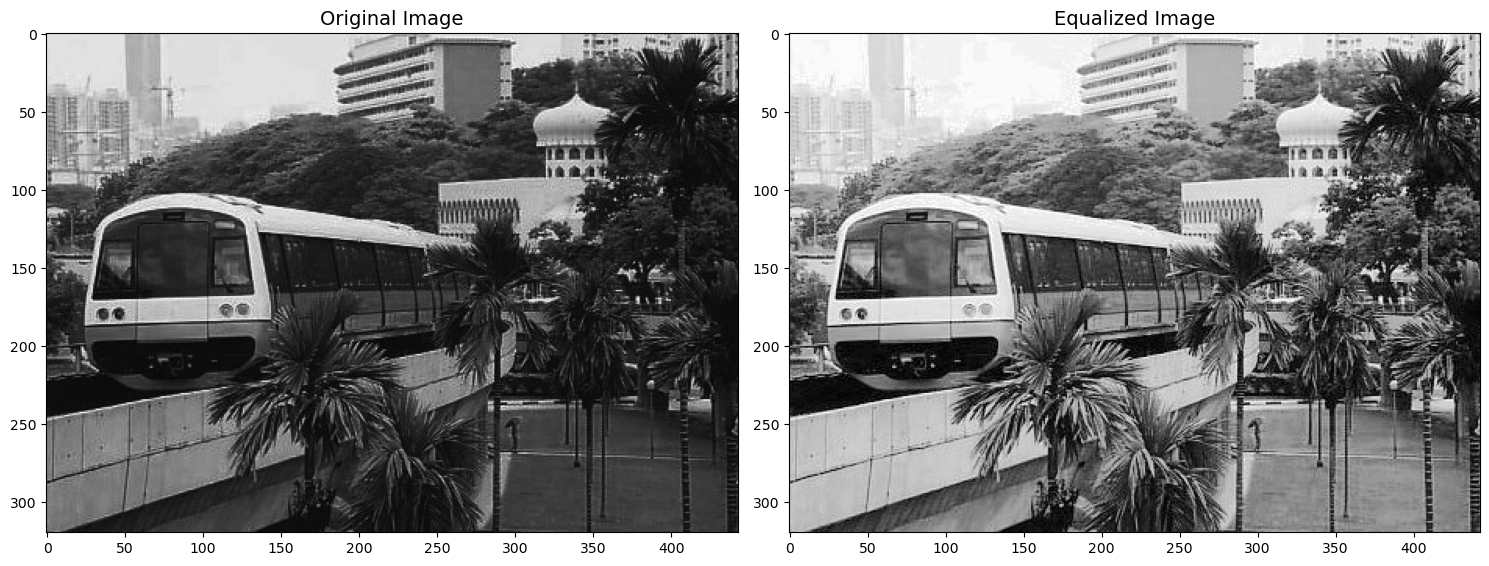

In [225]:
# Displaying the image after histogram equalization
display_images_side_by_side(P, P3, title1 = "Original Image", title2 = "Equalized Image")

**Are the histograms equalized? What arre the similarities and differences between the latter two histograms?**

In general, both histograms look more equalizzed than the original two image intensity histograms.

After equalization, the histograms show partial equalization rather than perfect uniformity. The 10-bin histogram appears much more equalized, with frequencies relatively around 13,000 to 15,000 pixels per bin across most of the intensity range, which is close to the ideal uniform ditribution. However, the 256-bin histogram reveals that perfect equalization was not achieved. While the intensity values are now spread across the full 0-255 range, still an improvement compared to the original clustered distribution, there is significant variation with many spikes, gaps and bins with zero pixels.

Still, the key similarity is that both histograms show intensity values distributed across the entire range rather than concentrated in dark regions like the original intensity histogram. In the image, we can also see that there are lesser gaps in the brighter area of pixel intensitgies, causing the resulting image to look brighter than the original.

### Part C - Rerunning of Histogram Equalization

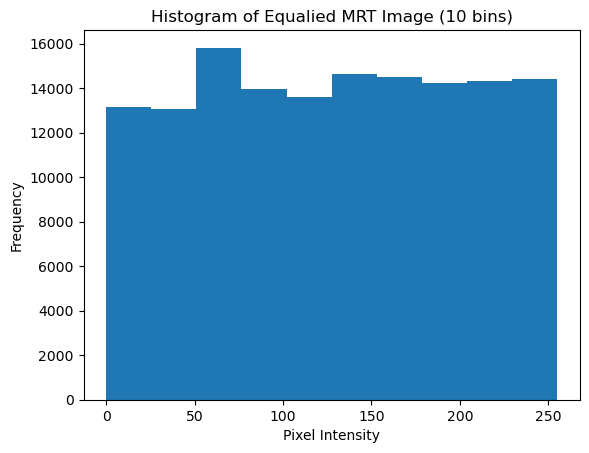

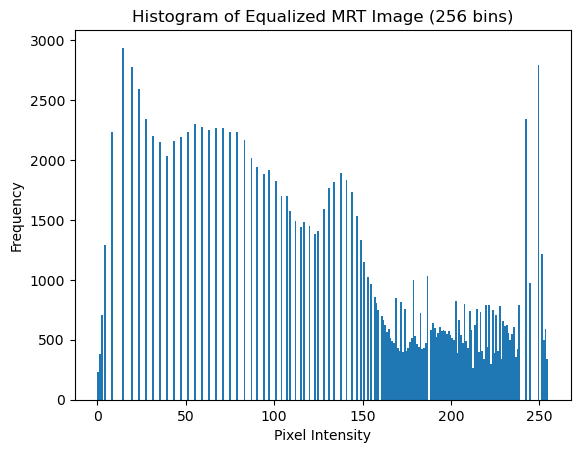

In [226]:
# Re-equalize hist on the equalized image
P4 = cv2.equalizeHist(P3)
# Redisplay the histograms for P4 with 10 and 256 bins
plot_intensity_histogram(P4, 10, (0, 255), "Histogram of Equalied MRT Image")
plot_intensity_histogram(P4, 256, (0, 255), "Histogram of Equalized MRT Image")

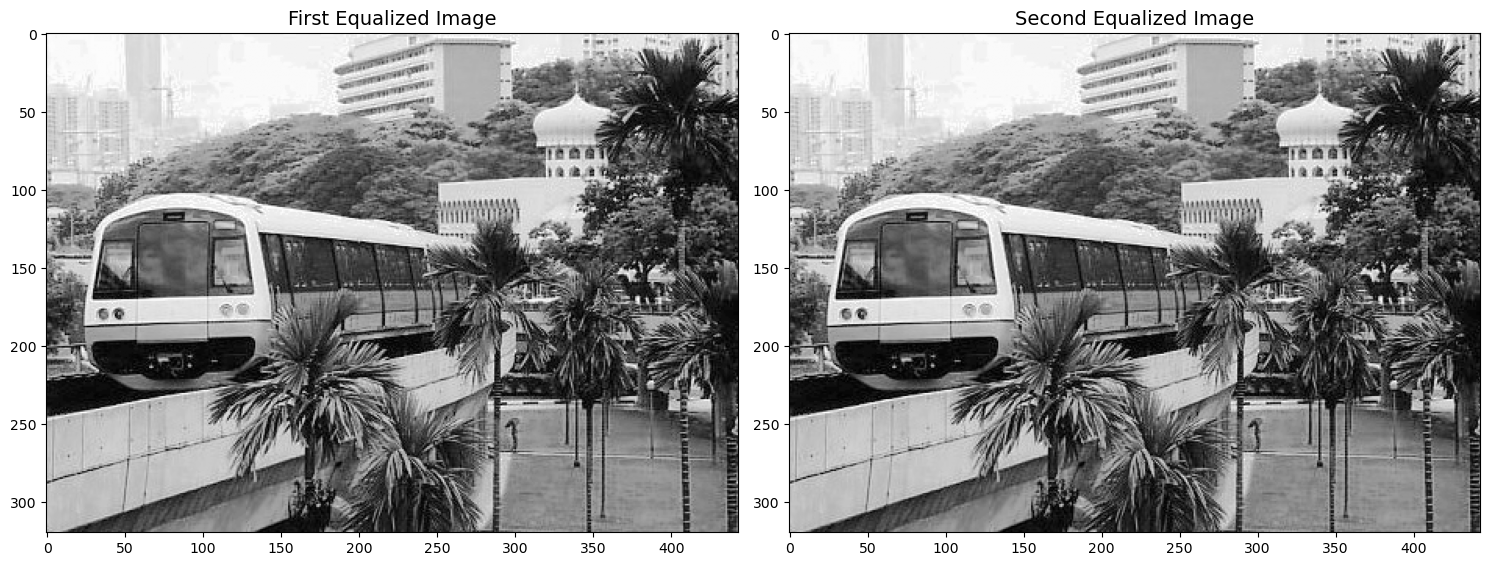

In [227]:
display_images_side_by_side(P3, P4, title1 = "First Equalized Image", title2 = "Second Equalized Image")

**Does the histogram become more uniform? Give suggestions as to why this occurs**

From analysis, the histograms show virtually no change compared to the first equalizations, they look nearly indentical. The histogram does not become more uniform after re-applying histogram. This occurs because histogram equalization is idempotent (applying it multiple time actually produces the same result as applying it once). Once pixel intensities have been redestributed to approximate a uniform distribution, the CDF of the equalized image is already approximately linear. If we reapply the transformation again, we are essentiall applying a near-identity transformation that maps most pixels back to or close to their current intensity values. This is partly due to the discrete nature of digital images, we cannot split bins that had multiple original intensity values merged, and we cannot fill empty bins where no pixels exist. Since the first equalization already maximally spread the available intensities across the 0-255 range, subsequent equalizations cannot improve uniformity further.

## 1.3 Linear Spatial Filtering

In linear spatial filtering, typically an input image f(x,y) is convolved with a small spatial filter
h(x,y) to create an output image g(x,y),
The function h(x,y) can be considered to be the impulse response of the filter system.
Another common name for h(x,y) is the point-spread function (PSF).

### Part A - Generate Gaussian Filters with Normalization

In [228]:
# Generate Gaussian filters using the formula: h(x,y) = (1/2πσ²) * e^(-(x²+y²)/2σ²)
# Size = dim of filter
# Sigma = how spread out the gaussian is , larger sigma = larger blur
def gaussian_filter(size, sigma):
    # Create coordinate grid centered at (0,0)
    # [-2, -1, 0, 1, 2] if size is 5
    axes = np.linspace(-(size//2), size // 2, size)
    # Create a mesh grid of the coordinates
    x, y = np.meshgrid(axes, axes)
 
    # formula: h(x,y) = (1/2πσ²) * e^(-(x²+y²)/2σ²)
    # First expression
    first_expn = 1.0 / (2.0 * np.pi * sigma**2.0)
    # Second expression
    second_expn = np.exp(-(x**2 + y**2) / (2.0 * sigma**2.0))
    # Combine
    gaussian = first_expn * second_expn
    # Normalize the gaussian
    return gaussian / gaussian.sum()

# Generate both filters
filter1 = gaussian_filter(5, 1.0)  # σ = 1.0, dim = 5
filter2 = gaussian_filter(5, 2.0)  # σ = 2.0, dim = 5

print("Filter 1 (σ=1.0):")
print(filter1, filter1.sum())
print("\nFilter 2 (σ=2.0):")
print(filter2, filter2.sum())


Filter 1 (σ=1.0):
[[0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.02193823 0.09832033 0.16210282 0.09832033 0.02193823]
 [0.01330621 0.0596343  0.09832033 0.0596343  0.01330621]
 [0.00296902 0.01330621 0.02193823 0.01330621 0.00296902]] 1.0

Filter 2 (σ=2.0):
[[0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.03832756 0.05576627 0.06319146 0.05576627 0.03832756]
 [0.03382395 0.04921356 0.05576627 0.04921356 0.03382395]
 [0.02324684 0.03382395 0.03832756 0.03382395 0.02324684]] 1.0


A quick analysis shows that the filter is indeed working, with higher values in the middle of the meshgrid, are rotationally symmetric and follow the pattern. The sigma determines the weight on the center pixel, which is why filter 1 has a larger value at the center than filter 2.

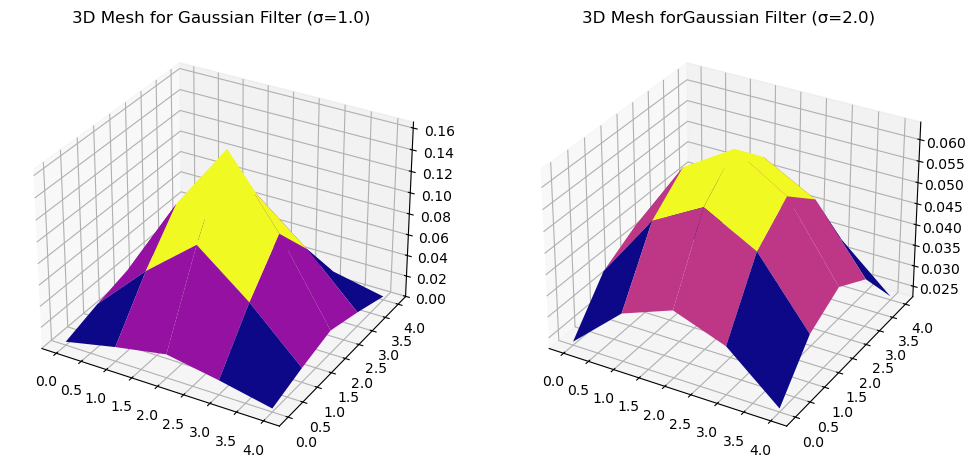

In [229]:
# Plotting of the gaussian filters as "3D meshes"
fig = plt.figure(figsize = (12, 6))
x,y = np.meshgrid(range(5), range(5))

# First subplot (σ=1.0)
ax1 = fig.add_subplot(1, 2, 1, projection = "3d")
ax1.set_title("3D Mesh for Gaussian Filter (σ=1.0)")
ax1.plot_surface(x, y, filter1, cmap = "plasma")

# Second subplot (σ=2.0)
ax2 = fig.add_subplot(1, 2, 2, projection = "3d")
ax2.set_title("3D Mesh forGaussian Filter (σ=2.0)")
ax2.plot_surface(x, y, filter2, cmap = "plasma")
plt.show()

Observations: The mesh for σ=1.0 looks like a sharp mountain peak, forming a steep needle-like spike that shoots up to 0.16. It drops off rapidly as we move away from the center, where msot of the mass is concentrated in the inner 3x3 region. In comparison for σ=2.0, we get a gentler hill forming a broad and more rounded dome with a lower peak, with much gradual slopes extending across the entire 5x5 area.

In image filtering, this means that after convolution,
For σ=1.0: The underlying output pixel is heavily influenced by the center pixel with 16% weight. It aims to keep the pixel mostly as is, jsut with some slight average with surrounding pixels.

For σ2.0: The output pixels would just be a weighted average of the entire 5x5 region, with center pixel having just a tiny bit more weight. As a result, this creates stronger smoothing - mostly resulting in blurrier looking images.

### Part B - Loading Image with Applied Gaussian Noise

In [230]:
image_with_gaussian_noise = load_image("../assets/lib-gn.jpg")
display_image(image_with_gaussian_noise, title = "Library with Gaussian Noise")
print_image_info(image_with_gaussian_noise, "Library with Gaussian Noise")

Library with Gaussian Noise Information:
Property             Value     
               Shape (333, 500)
           Data Type      uint8
        Total Pixels    166,500
          Dimensions          2
Memory Usage (bytes)    166,500
     Min Pixel Value          0
     Max Pixel Value        255
    Mean Pixel Value     131.83
  Standard Deviation      58.00


### Part C - Image Filtering using the Created Gaussian Filters

scipy provides functions for convolving 2d: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

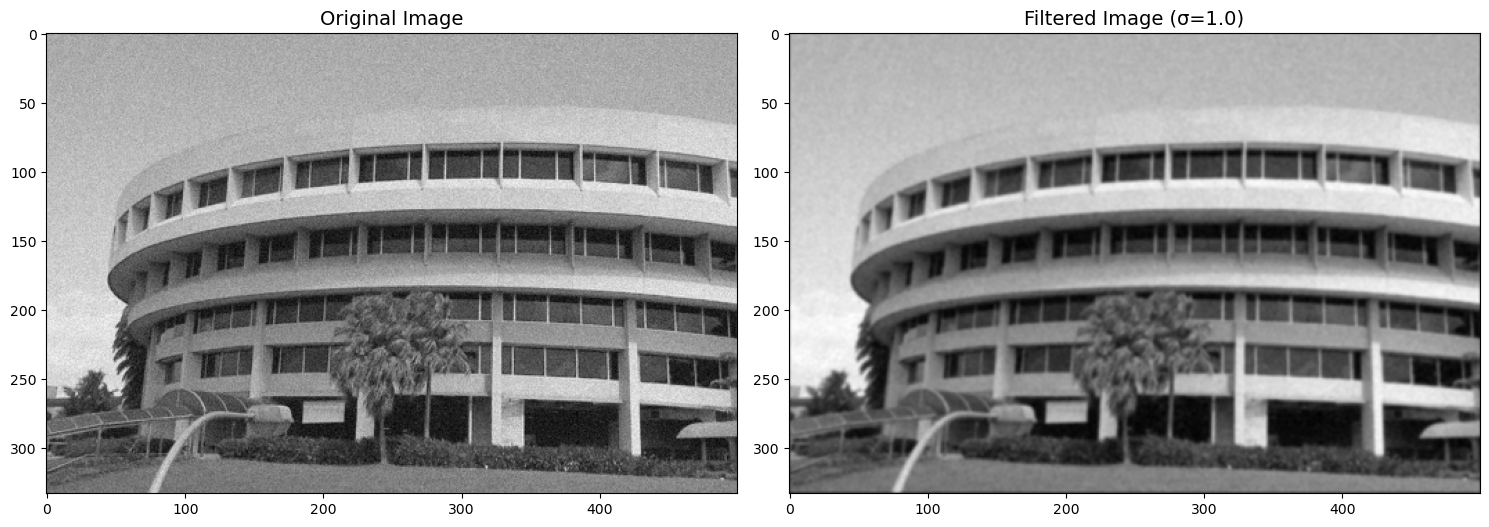

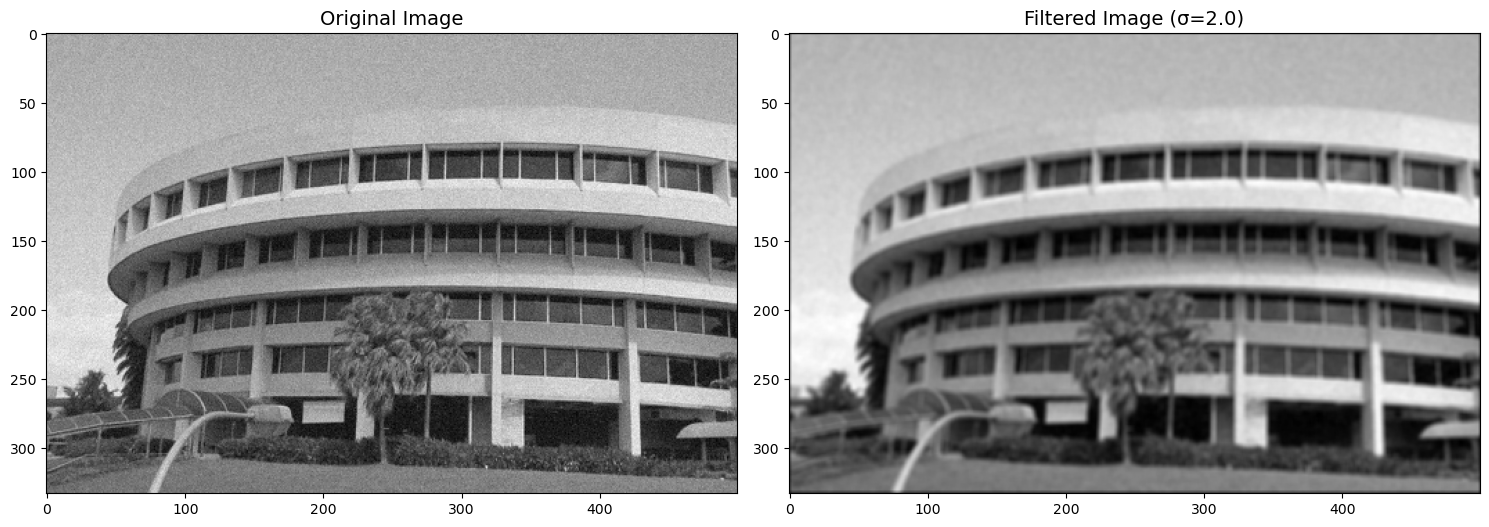

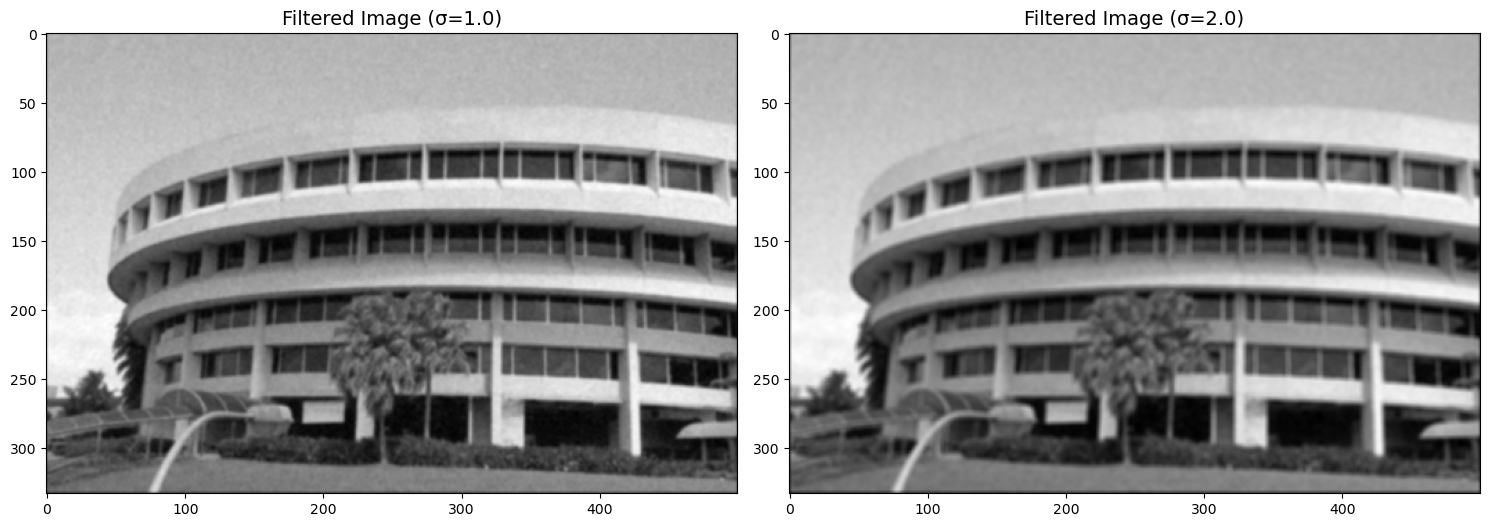

In [ ]:
# Recreate the filters to ensure nothing was changed accidentally in previous cells
filter1 = gaussian_filter(5, 1.0)
filter2 = gaussian_filter(5, 2.0)

filtered_image_1 = scipy.signal.convolve2d(image_with_gaussian_noise, filter1, mode = "same")
filtered_image_2 = scipy.signal.convolve2d(image_with_gaussian_noise, filter2, mode = "same")

display_images_side_by_side(image_with_gaussian_noise, filtered_image_1, title1 = "Original Image", title2 = "Filtered Image (σ=1.0)")
display_images_side_by_side(image_with_gaussian_noise, filtered_image_2, title1 = "Original Image", title2 = "Filtered Image (σ=2.0)")
display_images_side_by_side(filtered_image_1, filtered_image_2, title1 = "Filtered Image (σ=1.0)", title2 = "Filtered Image (σ=2.0)")

print_image_info(filtered_image_1, "Filtered Image (σ=1.0)")
print_image_info(filtered_image_2, "Filtered Image (σ=2.0)")
